# Segmentación de peatones

---

Ithiel Piñero Darias

Visión por computador

11/06/2021 

---



Sobre la base de datos de peatones para segmentación semántica. Partiendo de la
arquitectura base probar diferentes modificaciones de esta. Realizar un análisis de las
arquitecturas estudiadas

In [59]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Carga de imagenes

In [61]:
TRAIN_PATH_IMAGES = "/content/drive/MyDrive/data_segmentation/train/images/PennPed000"
TRAIN_PATH_MASK = "/content/drive/MyDrive/data_segmentation/train/mask/PennPed000"
TEST_PATH_IMAGES = "/content/drive/MyDrive/data_segmentation/test/images/FudanPed000"
TEST_PATH_MASK = "/content/drive/MyDrive/data_segmentation/test/mask/FudanPed000"

Carga de imagenes, convertimos todas las imágenes a tamaño 214x214 como se indica 

In [62]:
train_images = []
train_mask = []
test_images = []
test_mask = []

for i in range(1,97):
  if i < 10:
      filename = TRAIN_PATH_IMAGES+"0"+str(i)+".png"
  else:
      filename = TRAIN_PATH_IMAGES+str(i)+".png"
  img = cv2.imread(filename)
  img = cv2.resize(img, (214,214))
  #img = img/255.
  train_images.append(img)

for i in range(1,97):
  if i < 10:
    filename = TRAIN_PATH_MASK+"0"+str(i)+"_mask.png"
  else:
    filename = TRAIN_PATH_MASK+str(i)+"_mask.png"
 
  img = cv2.imread(filename)
  img = cv2.resize(img, (214,214))
  train_mask.append(img)

for i in range(1,75):
  if i < 10:
    filename = TEST_PATH_IMAGES+"0"+str(i)+".png"
  else:
    filename = TEST_PATH_IMAGES+str(i)+".png"
  
  img = cv2.imread(filename)
  img = cv2.resize(img, (214,214))
  #img = img/255
  test_images.append(img)

for i in range(1,75):
  if i < 10:
      filename = TEST_PATH_MASK+"0"+str(i)+"_mask.png"
  else:
      filename = TEST_PATH_MASK+str(i)+"_mask.png"
  img = cv2.imread(filename)
  img = cv2.resize(img, (214,214))
  test_mask.append(img)

Comprobamos que las imágenes se corresponden con su máscara.

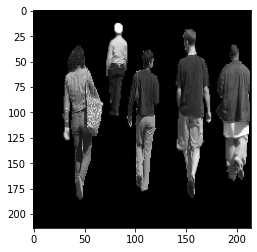

In [63]:
img = cv2.cvtColor(train_images[0], cv2.COLOR_BGR2GRAY)
mask = cv2.cvtColor(train_mask[0], cv2.COLOR_BGR2GRAY)
masked = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(masked, "gray")

In [64]:
train_images = np.array(train_images).astype(np.float32)
train_mask = np.array(train_mask).astype(np.float32)
test_images = np.array(test_images).astype(np.float32)
test_mask = np.array(test_mask).astype(np.float32)

In [65]:
for i in range(train_mask.shape[0]):
  train_mask[i][train_mask[i] > 1] = 1

for i in range(test_mask.shape[0]):
  test_mask[i][test_mask[i] > 1] = 1

Generación de la arquitectura recomendada en la documentación

In [66]:
import pandas as pd
df1 = pd.DataFrame(columns=['accuracy', 'time execution (seconds)', 'mean IoU'], index=["train", "test"])

In [67]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same", input_shape=(214, 214, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same"))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same"))
model.add(layers.Conv2D(64, (3, 3), padding="same"))
model.add(layers.Conv2DTranspose(64, (4,4), strides=(2,2)))
model.add(layers.Cropping2D(cropping=(1)))
model.add(layers.Conv2DTranspose(64, (4,4), strides=(2,2)))
model.add(layers.Cropping2D(cropping=(0)))
model.add(layers.Conv2D(2, (1, 1), padding="valid"))
model.add(layers.Dense(3,activation="softmax"))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(train_images,train_mask, epochs=10)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 214, 214, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 107, 107, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 107, 107, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 53, 53, 64)        36928     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 53, 53, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 108, 108, 64)     

Implementación de IoU

In [73]:
from sklearn.metrics import confusion_matrix

def IoU(real, pred):
  cm = confusion_matrix(real.flatten(),pred.flatten()) 
  sum_row = np.sum(cm,axis=1)
  sum_col = np.sum(cm,axis=0)
  true_positives = np.diagonal(cm)
  iou = true_positives / (sum_row + sum_col - true_positives)
  return sum(iou)

Realizamos la predicción tanto con el muestreo de entrenamiento como con el de test. Analizaremos el valor de IoU, accuracy y tiempo de ejecucción. 

In [74]:
import time
start_time = time.time()
train_predict = model.predict(train_images)
end_time = time.time()

train_predict[train_predict >= 0.5] = 1.
train_predict[train_predict < 0.5] = 0.

acc = np.mean(train_mask == train_predict)

iou = IoU(train_mask, train_predict)

df1.loc["train"] = [acc, end_time-start_time, iou]

In [75]:
import time
start_time = time.time()
test_predict = model.predict(test_images)
end_time = time.time()

test_predict[test_predict >= 0.5] = 1.
test_predict[test_predict < 0.5] = 0.

acc = np.mean(test_mask == test_predict)

iou = IoU(test_mask, test_predict)

df1.loc["test"] = [acc, end_time-start_time, iou]

Hemos logrado, una precisión en test del 82%, con un tiempo de ejecución de unos 10 segundos en ambos conjuntos (test y train). Por otra parte, el resultado final de meanIoU es de 86% en test y 80% en train. 

In [76]:
df1

,accuracy,time execution (seconds),mean IoU
train,0.765013,10.2522,0.800372
test,0.824404,10.2568,0.862346
